In [1]:
!nvidia-smi

Thu Jun  9 14:51:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# new tensorflow for RandomBrighness layer
!pip install -U tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip "/content/drive/My Drive/datasets/nomo_nailbiting/image_dataset.zip" -d "/content"

Archive:  /content/drive/My Drive/datasets/nomo_nailbiting/image_dataset.zip
replace /content/image_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

In [6]:
!ls "/content/image_dataset"

biting	no_biting


In [7]:
path_to_data = "/content/image_dataset"

class_names = ['no_biting', 'biting']

train_ds = image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    label_mode='binary',
    class_names=['no_biting', 'biting'],
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

val_ds = image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    label_mode='binary',
    class_names=['no_biting', 'biting'],
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


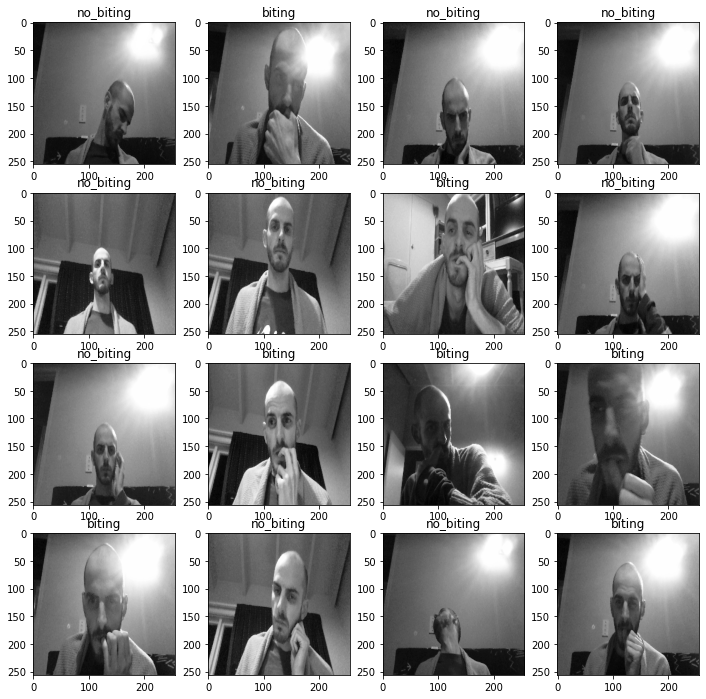

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# explore some data

fig, axes = plt.subplots(4, 4, figsize = (12, 12))

for x_batch, y_batch in train_ds.take(1).as_numpy_iterator():
    for img, label, ax in zip(x_batch, y_batch, axes.flat):
        ax.imshow(np.squeeze(img), cmap = 'Greys_r')
        ax.set_title(f'{class_names[int(label)]}')


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomRotation, RandomTranslation, RandomFlip, RandomBrightness


In [13]:
# order of data augmentation? brightness & contrast

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def model_init():

    model = Sequential([
        Rescaling(1/255, input_shape = (256, 256, 1)),
        #RandomBrightness(factor = 0.2, value_range = (0, 1)),
        RandomContrast(0.2),
        RandomZoom(0.2),
        RandomRotation(0.2),
        #RandomTranslation(0.2, 0.2),
        RandomFlip('horizontal_and_vertical'),
        Conv2D(16, (10, 10), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(32, (8, 8), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(64, (8, 8), activation = 'relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.4),
        Dense(1, activation ='sigmoid'),
    ])

    model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(0.000005),
                metrics = ['accuracy',Precision(), Recall()])

    return model

In [14]:
model = model_init()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 random_contrast_2 (RandomCo  (None, 256, 256, 1)      0         
 ntrast)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 1)      0         
 tation)                                                         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 247, 16)     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 5, restore_best_weights = True)

model = model_init()

history = model.fit(train_ds,
         validation_data = val_ds,
         epochs = 50,
         callbacks = [es]).history

In [ ]:
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()

In [ ]:
# best 72% accuracy

In [ ]:
model.save('cnn_model')

In [ ]:
!zip -r cnn_model.zip cnn_model

In [ ]:
!ls